In [1]:
# Start client parallel processing

from dask.distributed import Client

client = Client(n_workers=12)
client

Client Scheduler: tcp://127.0.0.1:57708 Dashboard: http://127.0.0.1:50011/status,Cluster Workers: 12 Cores: 24 Memory: 33.55 GB


### Load data

In [2]:
import sys
import os
import numpy as np
import xarray as xr

sys.path.append('../b_Temporal_Stack')
import xr_eotemp

data_loc = os.environ['WIN_SVR_DATA']+'Saldana/'

vars_ = list(map(lambda file: data_loc+file, ['opt_NDVI.nc','opt_LSWI.nc']))
int_ = list(map(lambda file: data_loc+file, ['NDVI.nc','LSWI.nc']))
int_der_ = list(map(lambda file: data_loc+file, ['NDVI_der.nc','LSWI_der.nc']))

orig_ts = xr.open_dataset(vars_[0], chunks={'y':100,'x':100,'time':-1})
int_ts = xr.open_dataset(int_[0], chunks={'y':100,'x':100,'time':-1})
der_ts = xr.open_dataset(int_der_[0], chunks={'y':100,'x':100,'time':-1})

#int_series = xr.open_mfdataset([int_location+x for x in os.listdir(int_location)],chunks={'y':100,'x':100,'time':22})
#
#optical_ts = xr.open_mfdataset(list(map(lambda x: vars_location+x, ['landsat.nc','sentinel.nc'])),
#                             chunks={'y':100,'x':100,'time':23})

In [104]:
int_ts.close()
der_ts.close()

In [106]:
ndvi_ts = xr.open_dataset(vars_[0], chunks={'y':100,'x':100,'time':-1})
lswi_ts = xr.open_dataset(vars_[1], chunks={'y':100,'x':100,'time':-1})

## Read fields shapefile

In [85]:
import geopandas as gpd
from shapely import geometry
fields_shp = gpd.read_file('/home/azalazar/data/saldana3.shp').to_crs({'init': 'epsg:32618'})

In [107]:
fields_shp

,IDLote,id,X20151127,X20151221,X20160107,geometry
0,21C914,1,NaN,5.0,NaN,"POLYGON ((500593.6043244276 424594.4964918615,..."
1,21C908,2,NaN,4.0,NaN,"POLYGON ((499894.357746025 424063.8923215767, ..."
2,21D813A,3,NaN,4.0,NaN,"POLYGON ((502685.0222099297 424989.3490379659,..."
3,21D823,4,1.0,2.0,NaN,"POLYGON ((501515.7494610766 425744.4833624031,..."
4,21C918,5,NaN,3.0,NaN,"POLYGON ((500376.993451801 425183.5859327142, ..."
5,21C919,6,NaN,3.0,4.0,"POLYGON ((499531.5955500824 425390.3938682243,..."
6,11B011A,7,NaN,4.0,NaN,"POLYGON ((499898.5690463202 428989.6078383457,..."
7,31D097,8,NaN,5.0,NaN,"POLYGON ((502616.531867381 430152.1011974501, ..."
8,31D091,9,NaN,5.0,NaN,"POLYGON ((502280.0686825864 430304.5789698638,..."
9,31E723,10,NaN,5.0,NaN,"POLYGON ((504624.8098139031 429436.7418436224,..."


In [135]:

for idx, polygon in fields_shp.iterrows():
    
    #polygon = fields_shp['geometry'][0]
    for date in ['X20151127','X20151221','X20160107']:
        if not np.isnan(polygon[date]):
            bb = polygon.bounds
            
            xrange = np.arange(bb[0], bb[2], 10)
            yrange = np.arange(bb[1], bb[3], 10)
            
            try:
                mask = dataset.mask.sel(x=xrange,y=yrange,method='nearest').load()
                array = dataset[band].where(mask).sel(x=xrange,y=yrange,method='nearest').load()
            
            except:
                array = dataset[band].sel(x=xrange,y=yrange,method='nearest').load()
    


5.0
4.0
4.0
1.0
2.0
3.0
3.0
4.0
4.0
5.0
5.0
5.0
2.0
3.0
4.0
1.0
2.0
4.0
5.0
5.0
3.0
4.0
3.0
4.0
3.0
4.0
1.0
1.0


### Display map to select area of interest

In [8]:
import pyproj
import IPython.display

from shapely import geometry
from ipyleaflet import Map
from ipyleaflet import DrawControl
from ipyleaflet.leaflet import TileLayer

In [8]:
%matplotlib inline

sat_url = "https://api.mapbox.com/styles/v1/asalazar/cjjjz8n1w56hx2snp8675oedp/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoiYXNhbGF6YXIiLCJhIjoiY2pqano3YngxMGNoMDNycXF2dDhqOTRkYiJ9.MecIVccMuRf5zhm4rk7qHA"

m = Map(center=(4.6767, -71.2653), zoom=5)
dc = DrawControl()
st = TileLayer(opacity=1.0, url=sat_url, zoom=0, max_zoom=25, attribution='<a href=’https://mapbox.com’>Mapbox</a>')

m.add_layer(st)
m.add_control(dc)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

- Retrieve area of interest from last drawn polygon in Map 

POLYGON ((501836.3643584131 431122.291358672, 501972.2520004144 431100.9608348549, 502196.1761029362 431150.706660394, 502284.3195147479 431380.1798318248, 501783.9548346003 431571.8369685897, 501736.3296055955 431481.9709571093, 501745.8781276896 431432.2302977055, 501836.3643584131 431122.291358672))


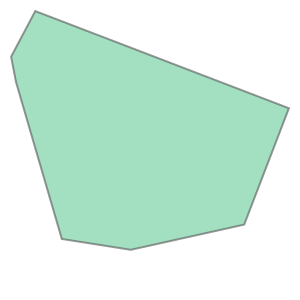

In [12]:
# Projection of the map
wgs84 = pyproj.Proj(init='epsg:4326')
# Projection of the dataset
wgs84_18N = pyproj.Proj(init='epsg:32618')
# Get and reproject geom coordinates
coords = [pyproj.transform(wgs84,wgs84_18N,x,y) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
# Make shapely polygon
polygon = geometry.polygon.Polygon(coords)
# Display polygon
print(polygon.wkt)
IPython.display.display(polygon)

- Verfiy that the polygon is correctly geo-referenced in the dataset by visualization of real color RGB bands 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


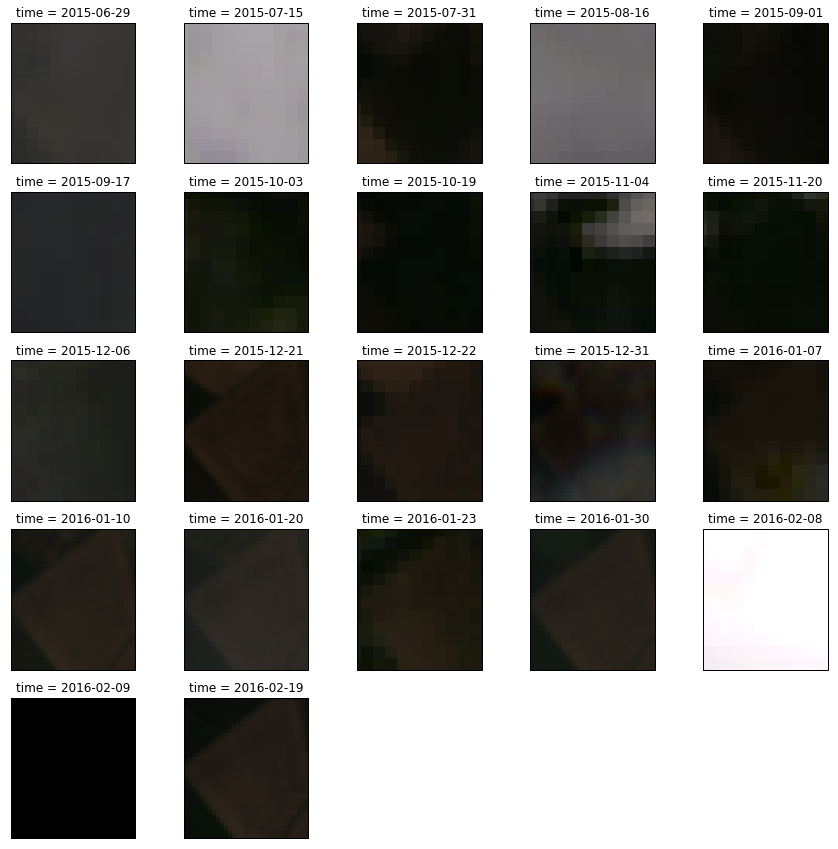

In [22]:
optical_ts = xr.open_mfdataset(list(map(lambda file: os.environ['WIN_SVR_DATA']+'Saldana2/vars/'+file, ['landsat.nc','sentinel.nc'])))
optical_subset = optical_ts.sel(x=xrange,y=yrange,method='nearest').load()

optical_subset.eotemp.plot_RGB()

### Plot time-series

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_polygon_ts(dataset, band, polygon, zlims=(0,1)):
    """
    Plot time-series of a band for points within a polygon of interest
    
    Args:
        dataset (xarray.Dataset): dataset with time series data
        band (str): band to plot
        polygon (shapely.geometry.polygon.Polygon): area of interest
        zlims(tuple(int,int)): limits to y-axis of plot (min,max)
    
    """
    
    bb = polygon.bounds
    
    xrange = np.arange(bb[0], bb[2], 10)
    yrange = np.arange(bb[1], bb[3], 10)
    
    try:
        mask = dataset.mask.sel(x=xrange,y=yrange,method='nearest').load()
        array = dataset[band].where(mask).sel(x=xrange,y=yrange,method='nearest').load()
    except:
        array = dataset[band].sel(x=xrange,y=yrange,method='nearest').load()
    
    array_copy = array.copy(deep=True)
    array_copy.coords['pmask'] = (('y','x','time'), np.zeros((array_copy.y.values.shape[0],
                                                              array_copy.x.values.shape[0],
                                                              array_copy.time.values.shape[0])))    
    
    fig, axes = plt.subplots(ncols=1)
    
    axes.set_ylim(zlims[0],zlims[1])
    
    for x in array.x.values:
        for y in array.y.values:
            if geometry.point.Point(x,y).within(polygon):
                array.sel(x=x,y=y).plot.line(marker='o')
                length = array.sel(x=x,y=y).time.values.shape
                array_copy['pmask'].loc[dict(x=x,y=y)] = np.repeat(1, length[0])
            else:
                pass
    
    axes.set_title('Interpolated {} time-series'.format(band))
    
    plt.tight_layout()
    plt.grid()
    plt.show()
    
    return array_copy

In [7]:
import numpy as np
period = slice(np.datetime64('2015-07-01'), np.datetime64('2016-03-03'))

In [9]:
from interpolatets import *

In [62]:
from scipy import signal
from scipy import ndimage

def interpolate_band(dataarray, intdates, der, intp1d_fun):
    """
    Interpolate time series in a data array for the specified dates. Tries to
    parallelize using dask.
    
    Args:
        dataarray (xarray.DataArray): data array (time,y,x) with time series
        intdates (np.ndarray(np.datetime64)): array of dates to interpolate
        der (bool): if the first derivative is beign calculated
    Returns:
        result (xarray.DataArray): data array with interpolated values stacked
                                    in new dimension itime (interpolated-time)
    """
    # Convert datetime objects to int
    time_base = min(pd.to_datetime(dataarray.time.values))
    
    int_orig_times = (pd.to_datetime(dataarray.time.values) - time_base).days.values
    
    int_new_times = (pd.to_datetime(intdates) - time_base).days.values
    
    # Apply ufunc-- inputs xr.DataArray and dates for interpolation
    # returns data array with interpolated values for int_dates
    result = xr.apply_ufunc(ufunc_cubic_spline, dataarray,
                            input_core_dims=[['time']],
                            output_core_dims=[['time']],
                            exclude_dims=frozenset(['time']),
                            kwargs={'axis': -1,
                                    'orig_times': int_orig_times,
                                    'new_times': int_new_times,
                                    'der': der,
                                    'fun':intp1d_fun},
                            dask='parallelized',
                            output_dtypes=[np.float32],
                            output_sizes={'time':intdates.shape[0]})
    result['time'] = ('time', intdates)
    return result

def ufunc_cubic_spline(array, orig_times, new_times, axis, der, fun):
    """
    Ufunc to fit a cubic spline on eo time series (y=f(x)) and interpolate
    values for the specified dates.
    
    Args:
        array (np.ndarray): 3-D array with shape (y,x,time) having the response
                                values (y), earth observation bands values
        axis (int): axis of the time dimension to apply the 
        orig_times: dates of the original earth observation images
        new_times: dates to interpolate
        
    Returns:
        interpolated (np.ndarray): 3-D array with interpolated values, stacked
                                    by interpolated dates in the third axis.
    """
    
    # Fit cubic spline and interpolate dates
    interpolated = np.apply_along_axis(fun,
                                       axis,
                                       array,
                                       orig_times=orig_times,
                                       new_times=new_times,
                                       der=der)
    
    return interpolated

def int_cubic_spline(y, orig_times, new_times, der):
    """
    Cubic spline fitting and interpolation removing NaN values.
    
    Args:
        y (np.ndarray): 1D array with response to fit spline
        orig_times (np.ndarray): 1D array with predictor to fit spline
        new_times (np.ndarray): 1D array with predictor values to interpolate
    
    Returns:
        interpolated (np 1d-array): interpolated values
    """
    # Filter NaNs in response
    nans = np.isnan(y)
    
    #Try sv filtering
    try:
        #print('filt_applied')
    #    if y[~nans].shape[0]//4 > 3:
    #        porder = 3
    #    else:
    #        porder = 2
    #    y_vals = signal.savgol_filter(y[~nans], y[~nans].shape[0]//3, porder)
        
    #Apply gaussian filter    
        y_vals = ndimage.filters.gaussian_filter(y[~nans], 2)
        
    except:
        warnings.warn('filter could not be applied')
        y_vals = y[~nans]
    # Try to fit cubic spline with filtered y values
    try:
        
        spl = interpolate.CubicSpline(orig_times[~nans], y_vals, extrapolate=False)
        
        if der:
            deriv = spl.derivative()
            interpolated = deriv(new_times)
        else:
            interpolated = spl(new_times)
    
    except ValueError:
        #e = sys.exc_info()
        #print('{} {} {}'.format(e[0],e[1],e[2]))
        warnings.warn('CubicSpline could not be fitted for one or more pixels')
        ## When spline cannot be fitted(not enought data), return NaN
        interpolated = np.empty(new_times.shape[0])
        interpolated[:] = np.nan
        
    return interpolated

#from scipy.interpolate import UnivariateSpline
def int_cubic_univarspline(y, orig_times, new_times, der):
    """
    Cubic spline fitting and interpolation removing NaN values.
    
    Args:
        y (np.ndarray): 1D array with response to fit spline
        orig_times (np.ndarray): 1D array with predictor to fit spline
        new_times (np.ndarray): 1D array with predictor values to interpolate
    
    Returns:
        interpolated (np 1d-array): interpolated values
    """
    # Filter NaNs in response
    nans = np.isnan(y)
    
    # Try to fit cubic spline with filtered y values
    try:
        #print(y[~nans].shape[0])
        if y[~nans].shape[0] > 0:
            spl = interpolate.UnivariateSpline(orig_times[~nans], y[~nans], ext=3)#, extrapolate=False)
            spl.set_smoothing_factor(0.15)
        else:
            raise ValueError
        
        if der:
            deriv = spl.derivative()
            interpolated = deriv(new_times)
        else:
            interpolated = spl(new_times)
    
    except ValueError:
        #e = sys.exc_info()
        #print('{} {} {}'.format(e[0],e[1],e[2]))
        warnings.warn('CubicSpline could not be fitted for one or more pixels')
        ## When spline cannot be fitted(not enought data), return NaN
        interpolated = np.empty(new_times.shape[0])
        interpolated[:] = np.nan
        
    return interpolated


In [103]:
a = 0
if a:
    print(100)

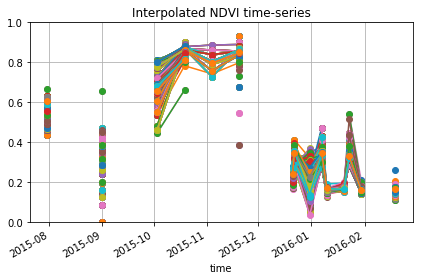

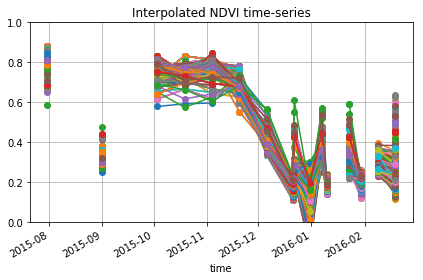

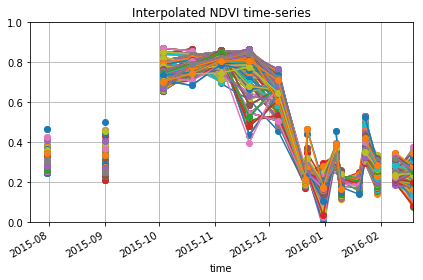

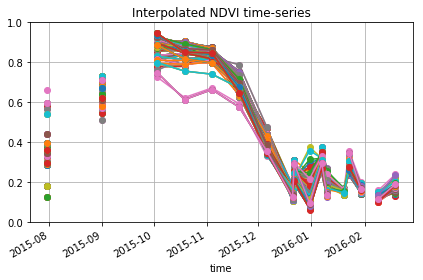

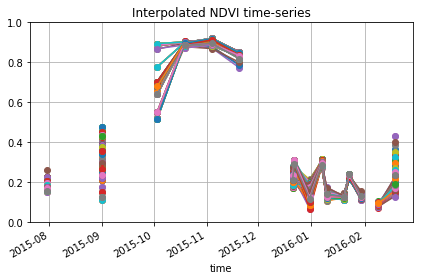

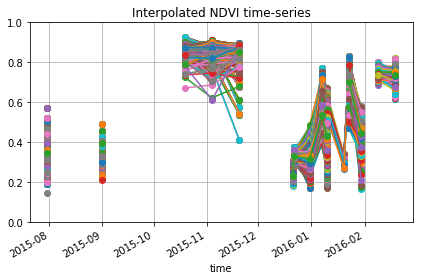

In [87]:
p1 = plot_polygon_ts(orig_ts.where(orig_ts.mask), 'NDVI', fields_shp['geometry'][0], zlims=(0,1))
p2 = plot_polygon_ts(orig_ts.where(orig_ts.mask), 'NDVI', fields_shp['geometry'][7], zlims=(0,1))
p3 = plot_polygon_ts(orig_ts.where(orig_ts.mask), 'NDVI', fields_shp['geometry'][8], zlims=(0,1))
p4 = plot_polygon_ts(orig_ts.where(orig_ts.mask), 'NDVI', fields_shp['geometry'][9], zlims=(0,1))
p5 = plot_polygon_ts(orig_ts.where(orig_ts.mask), 'NDVI', fields_shp['geometry'][13], zlims=(0,1))
p6 = plot_polygon_ts(orig_ts.where(orig_ts.mask), 'NDVI', fields_shp['geometry'][14], zlims=(0,1))

In [88]:
i1 = interpolate_band(p1.where(p1.pmask==1), int_ts.time.values, False, int_cubic_spline)
i2 = interpolate_band(p2.where(p2.pmask==1), int_ts.time.values, False, int_cubic_spline)
i3 = interpolate_band(p3.where(p3.pmask==1), int_ts.time.values, False, int_cubic_spline)
i4 = interpolate_band(p4.where(p4.pmask==1), int_ts.time.values, False, int_cubic_spline)
i5 = interpolate_band(p5.where(p5.pmask==1), int_ts.time.values, False, int_cubic_spline)
i6 = interpolate_band(p6.where(p6.pmask==1), int_ts.time.values, False, int_cubic_spline)

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels
/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels


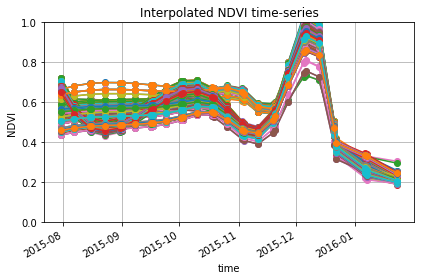

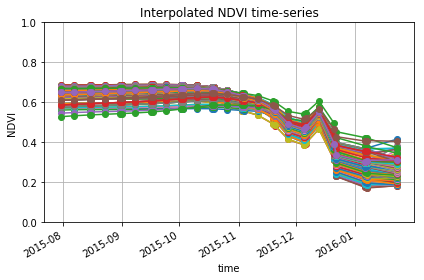

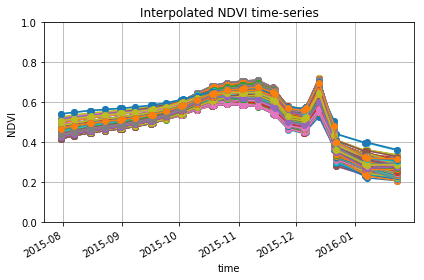

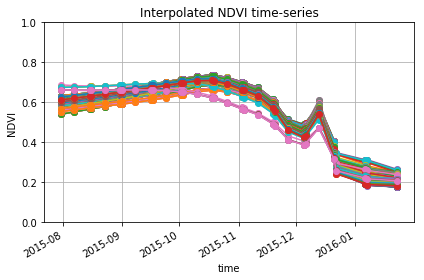

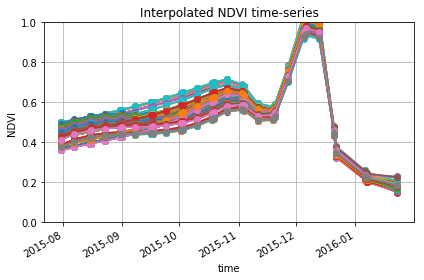

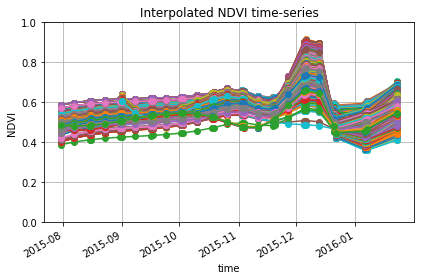

In [91]:
plot_polygon_ts(xr.Dataset({'NDVI':i1}), 'NDVI', fields_shp['geometry'][0], zlims=(0,1))
plot_polygon_ts(xr.Dataset({'NDVI':i2}), 'NDVI', fields_shp['geometry'][7], zlims=(0,1))
plot_polygon_ts(xr.Dataset({'NDVI':i3}), 'NDVI', fields_shp['geometry'][8], zlims=(0,1))
plot_polygon_ts(xr.Dataset({'NDVI':i4}), 'NDVI', fields_shp['geometry'][9], zlims=(0,1))
plot_polygon_ts(xr.Dataset({'NDVI':i5}), 'NDVI', fields_shp['geometry'][13], zlims=(0,1))
plot_polygon_ts(xr.Dataset({'NDVI':i6}), 'NDVI', fields_shp['geometry'][14], zlims=(0,1))
None

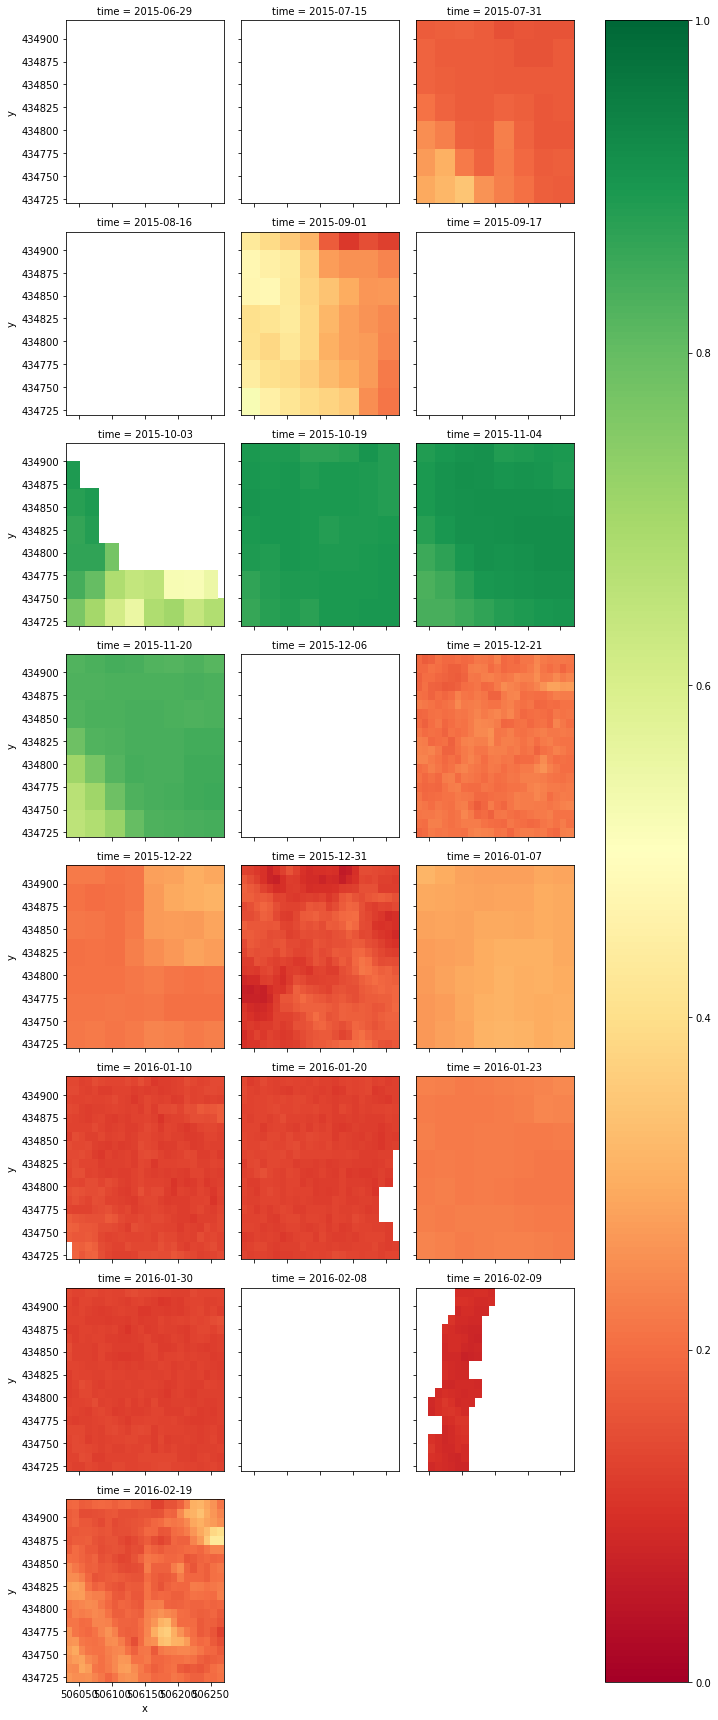

In [93]:
p5.plot(col='time', col_wrap=3, cmap='RdYlGn', vmin=0, vmax=1)

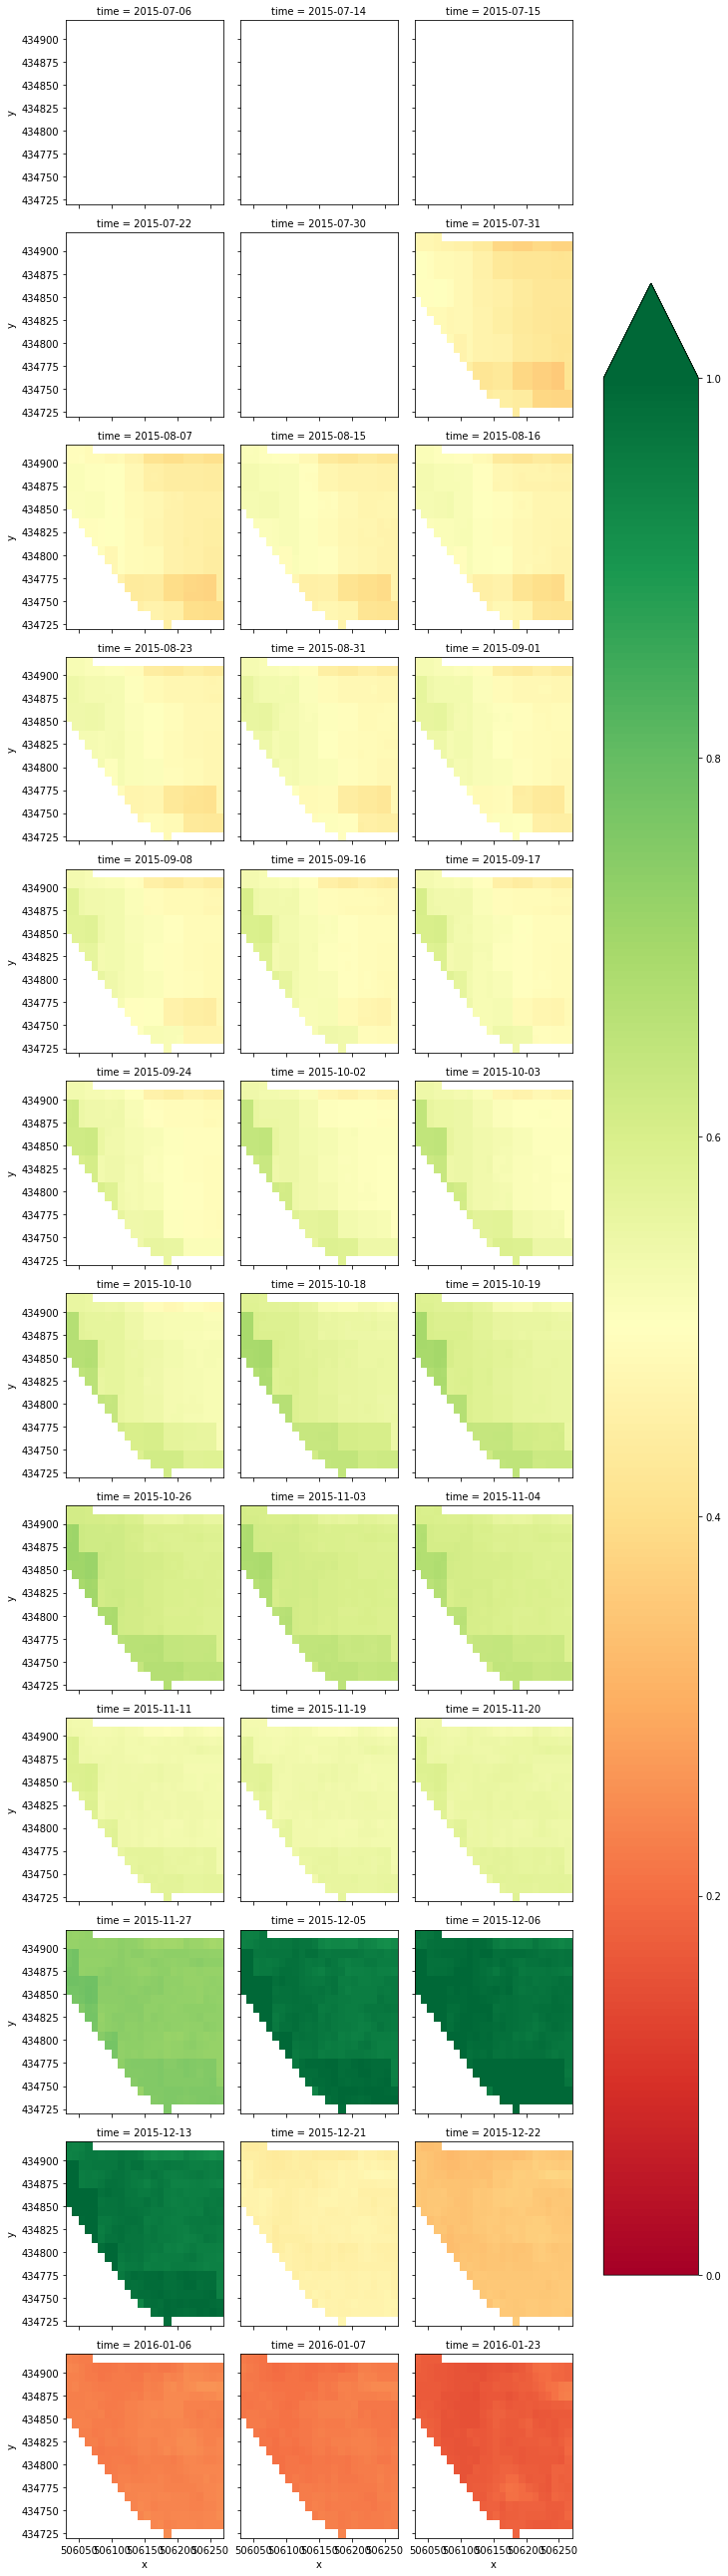

In [92]:
i5.plot(col='time', col_wrap=3, cmap='RdYlGn', vmin=0, vmax=1)

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels


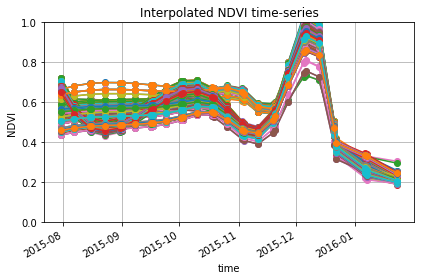

In [63]:
interpolation2 = interpolate_band(pol1.where(pol1.pmask==1), int_ts.time.values, False, int_cubic_spline)
plot_polygon_ts(xr.Dataset({'NDVI':interpolation2}), 'NDVI', polygon, zlims=(0,1))
None

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:153: UserWarning: CubicSpline could not be fitted for one or more pixels


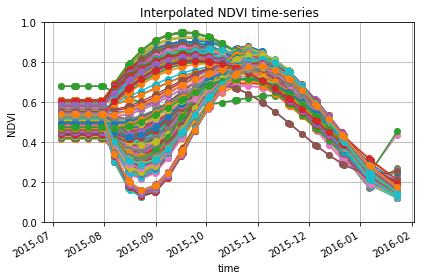

In [60]:
#With smoothing spline

interpolation2 = interpolate_band(pol1.where(pol1.pmask==1), int_ts.time.values, False, int_cubic_univarspline)
plot_polygon_ts(xr.Dataset({'NDVI':interpolation2}), 'NDVI', polygon, zlims=(0,1))
None

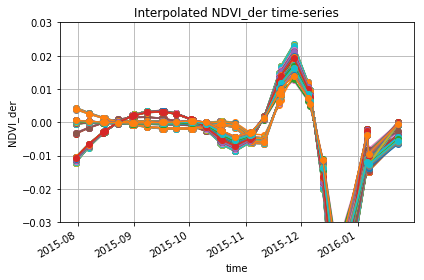

In [48]:
interpolation2_der = interpolate_band(pol1.where(pol1.pmask==1), int_ts.time.values, True, int_cubic_spline)
plot_polygon_ts(xr.Dataset({'NDVI_der':interpolation2_der}), 'NDVI_der', polygon, zlims=(-0.03,0.03))
None

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels


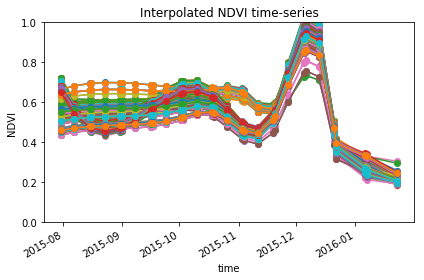

In [36]:
interpolation3 = interpolate_band(pol1.where(pol1.pmask==1), int_ts.time.values, False, int_cubic_spline)
plot_polygon_ts(xr.Dataset({'NDVI':interpolation3}), 'NDVI', polygon, zlims=(0,1))
None

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels


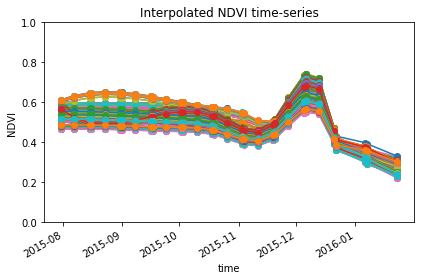

In [24]:
## Kernel smoothing with 3 sd and 

interpolation4 = interpolate_band(pol1.where(pol1.pmask==1), int_ts.time.values, False, int_cubic_spline)
plot_polygon_ts(xr.Dataset({'NDVI':interpolation4}), 'NDVI', polygon, zlims=(0,1))
None

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels


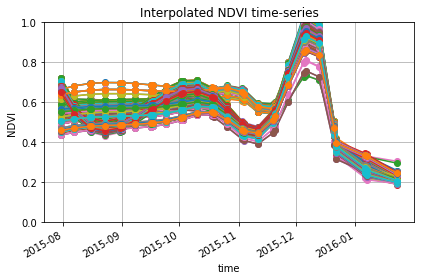

In [80]:
## Kernel smoothing with 5 sd and 

interpolation5 = interpolate_band(pol1.where(pol1.pmask==1), int_ts.time.values, False, int_cubic_spline)
plot_polygon_ts(xr.Dataset({'NDVI':interpolation5}), 'NDVI', polygon, zlims=(0,1))
None

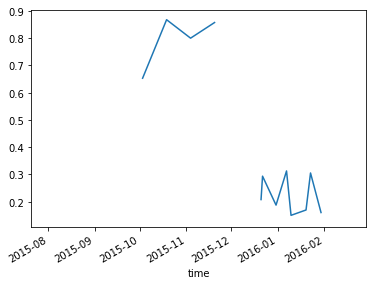

In [79]:
pol1.where(pol1.pmask==1).mean(dim=['x','y']).plot()

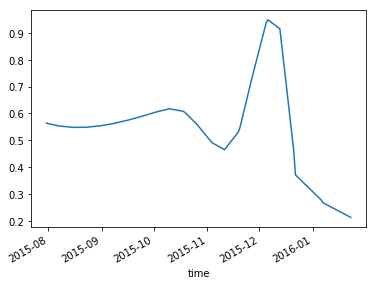

In [81]:
interpolation5.mean(dim=['x','y']).plot()

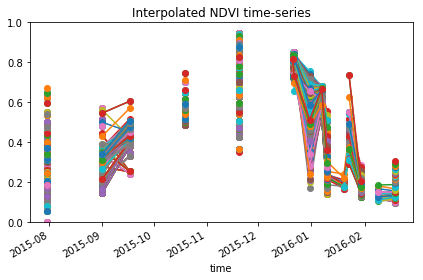

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels


In [29]:
pol2 = plot_polygon_ts(orig_ts.where(orig_ts.mask), 'NDVI', fields_shp['geometry'][1], zlims=(0,1))

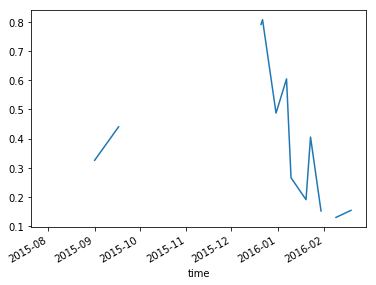

In [77]:
pol2.where(pol2.pmask==1).mean(dim=['x','y']).plot()

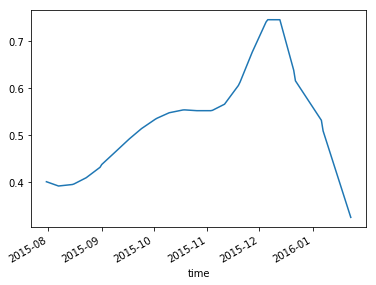

In [75]:
interpolation.mean(dim=['x','y']).plot()

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: CubicSpline could not be fitted for one or more pixels


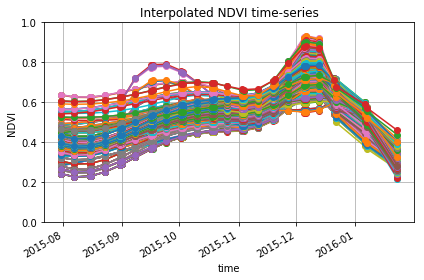

In [74]:
interpolation = interpolate_band(pol2.where(pol2.pmask==1), int_ts.time.values, False, int_cubic_spline)
plot_polygon_ts(xr.Dataset({'NDVI':interpolation}), 'NDVI', fields_shp['geometry'][1], zlims=(0,1))
None

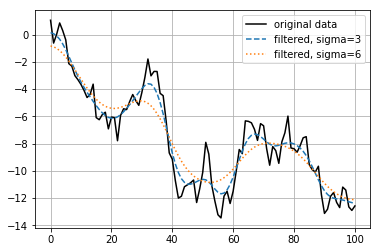

In [27]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

np.random.seed(280490)
x = np.random.randn(101).cumsum()
y3 = gaussian_filter1d(x, 3)
y6 = gaussian_filter1d(x, 6)
plt.plot(x, 'k', label='original data')
plt.plot(y3, '--', label='filtered, sigma=3')
plt.plot(y6, ':', label='filtered, sigma=6')
plt.legend()
plt.grid()
plt.show()

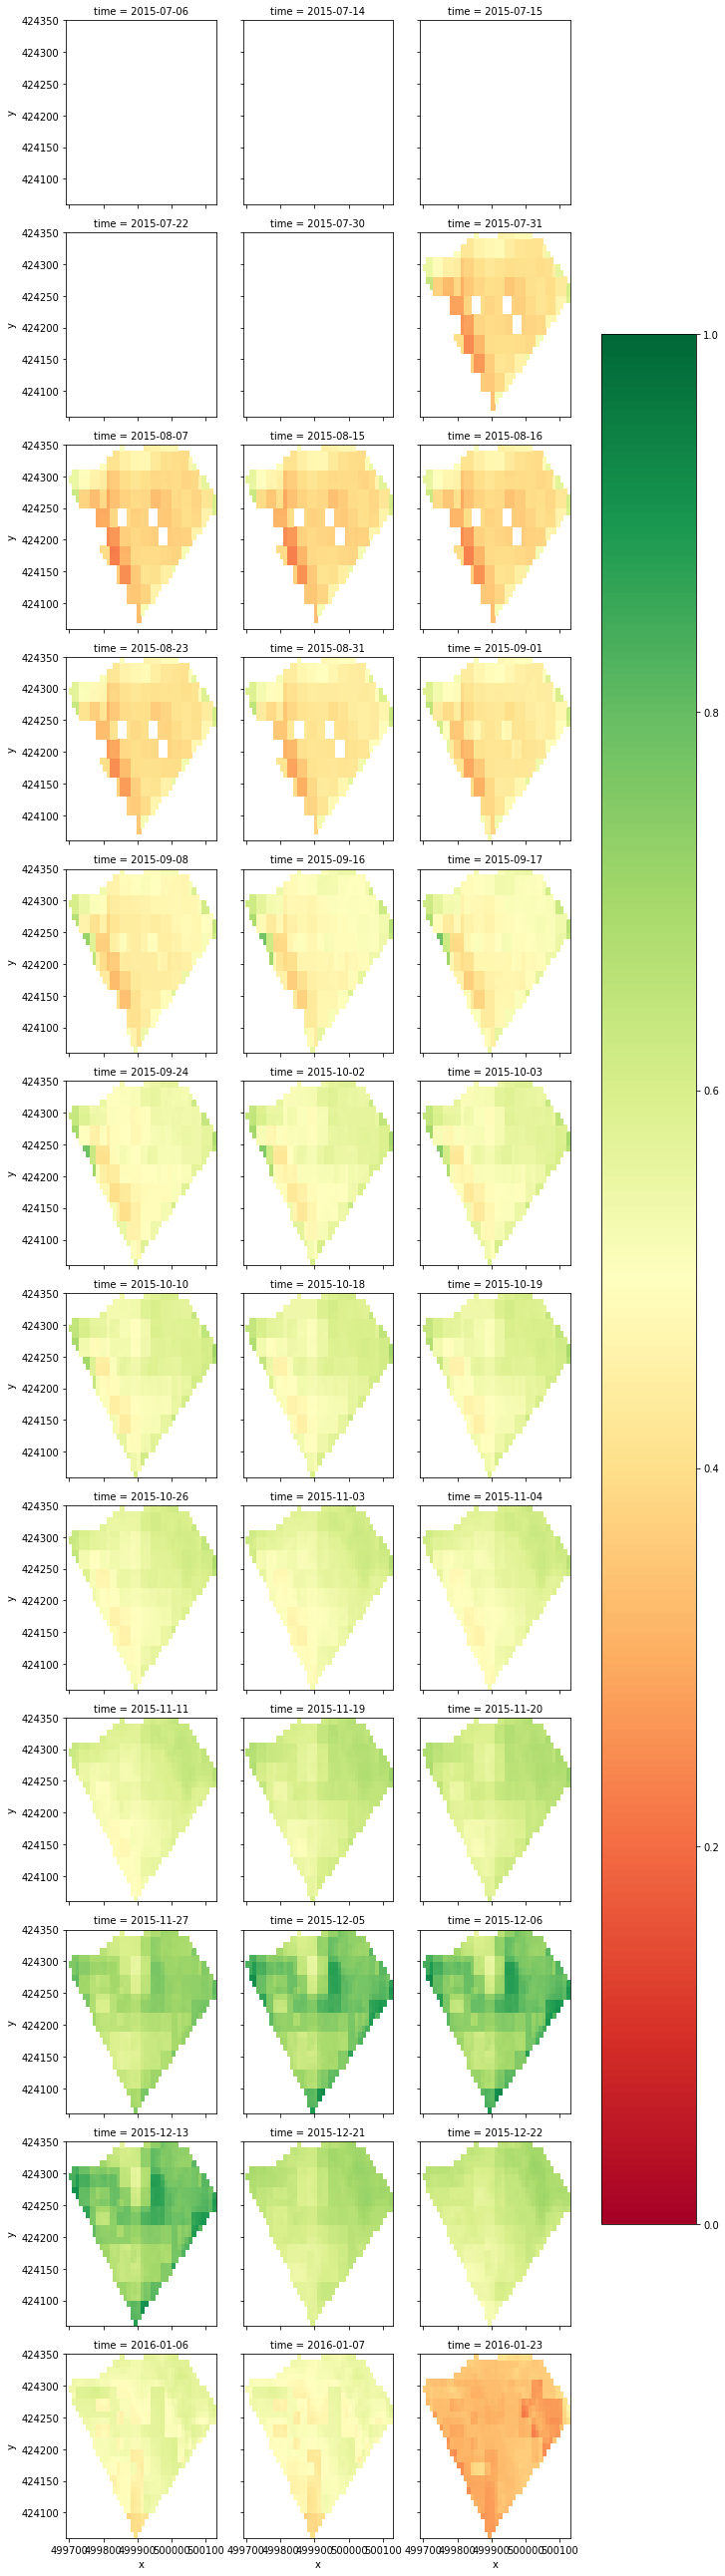

In [64]:
interpolation.plot(col='time', col_wrap=3, cmap='RdYlGn', vmin=0, vmax=1)

In [19]:
interpolation2 = interpolate_band(pol1.where(pol1.pmask==1), int_ts.time.values, False, int_cubic_univarspline)
plot_polygon_ts(xr.Dataset({'NDVI':interpolation2}), 'NDVI', polygon, zlims=(-1,1.5))
None

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:147: UserWarning: CubicSpline could not be fitted for one or more pixels


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f56ff138bf8> (for post_execute):


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:106: UserWarning: CubicSpline could not be fitted for one or more pixels


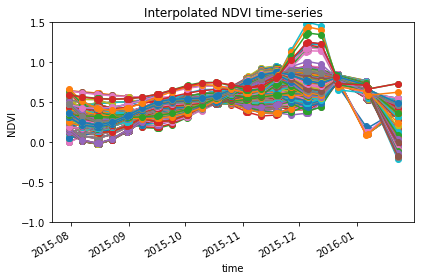

In [15]:
interpolation2 = interpolate_band(pol1.where(pol1.pmask==1), int_ts.time.values, False, int_cubic_spline)
plot_polygon_ts(xr.Dataset({'NDVI':interpolation2}), 'NDVI', polygon, zlims=(-1,1.5))
None

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:134: UserWarning: CubicSpline could not be fitted for one or more pixels


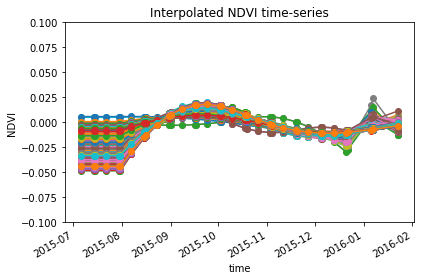

In [73]:
interpolation2 = interpolate_band(pol1.where(pol1.pmask==1), int_ts.time.values, True, int_cubic_univarspline)
plot_polygon_ts(xr.Dataset({'NDVI':interpolation2}), 'NDVI', polygon, zlims=(-0.1,0.1))
None

/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: CubicSpline could not be fitted for one or more pixels


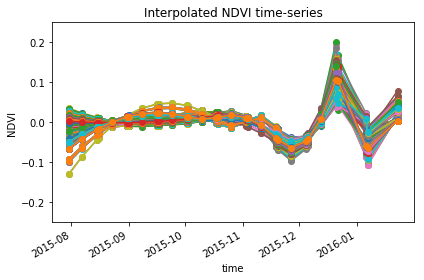

In [74]:
interpolation2 = interpolate_band(pol1.where(pol1.pmask==1), int_ts.time.values, True, int_cubic_spline)
plot_polygon_ts(xr.Dataset({'NDVI':interpolation2}), 'NDVI', polygon, zlims=(-0.25,0.25))
None

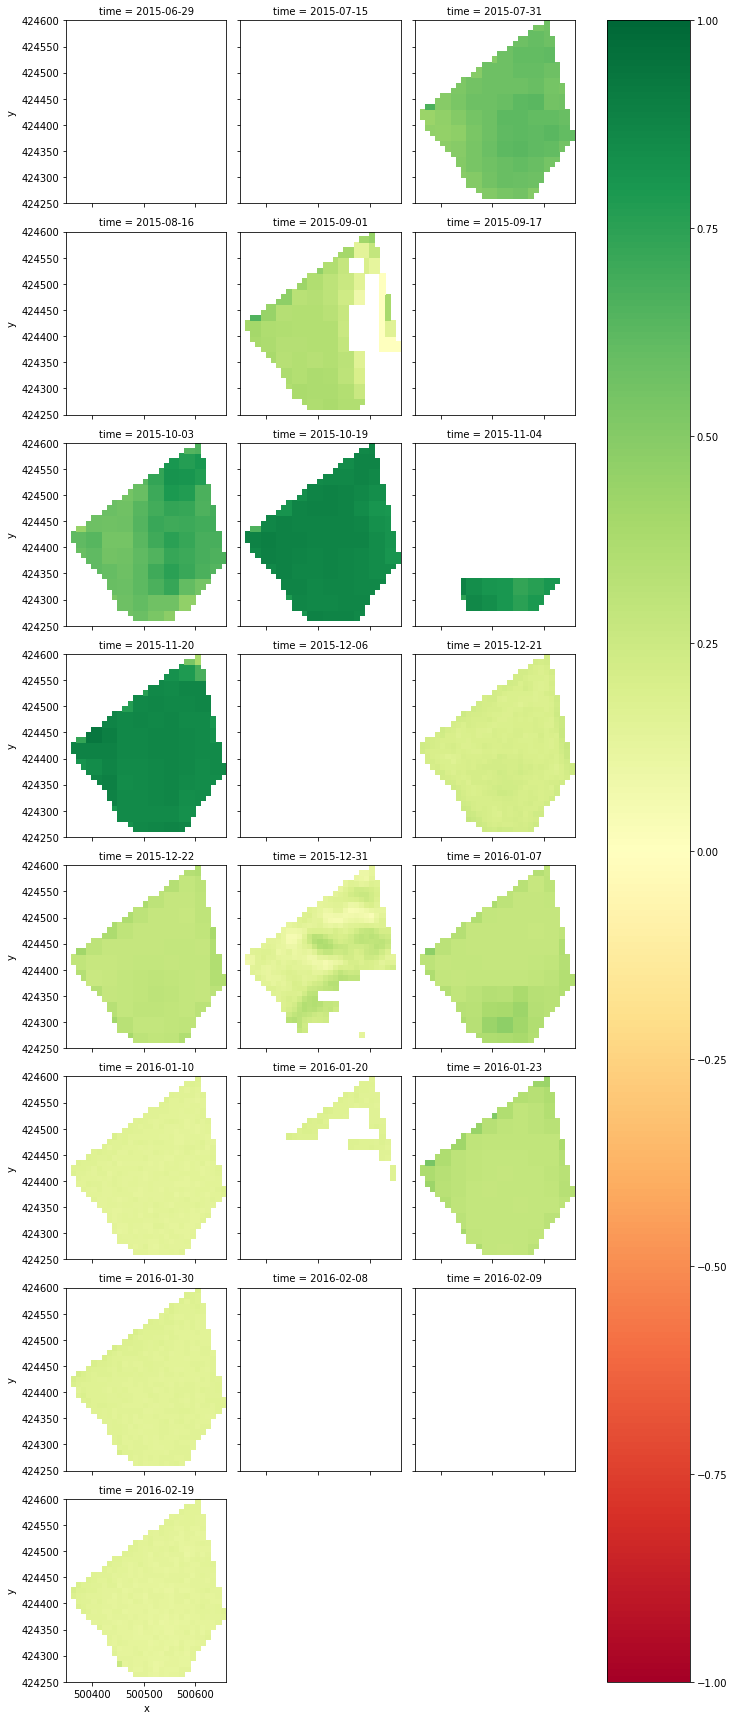

In [61]:
pol1.where(pol1.pmask==1).plot(col='time', col_wrap=3, cmap='RdYlGn', vmin=-1, vmax=1)

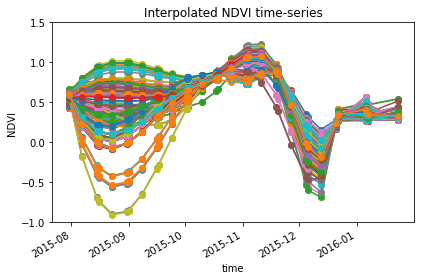

In [32]:
plot_polygon_ts(int_ts, 'NDVI', polygon, zlims=(-1,1.5))

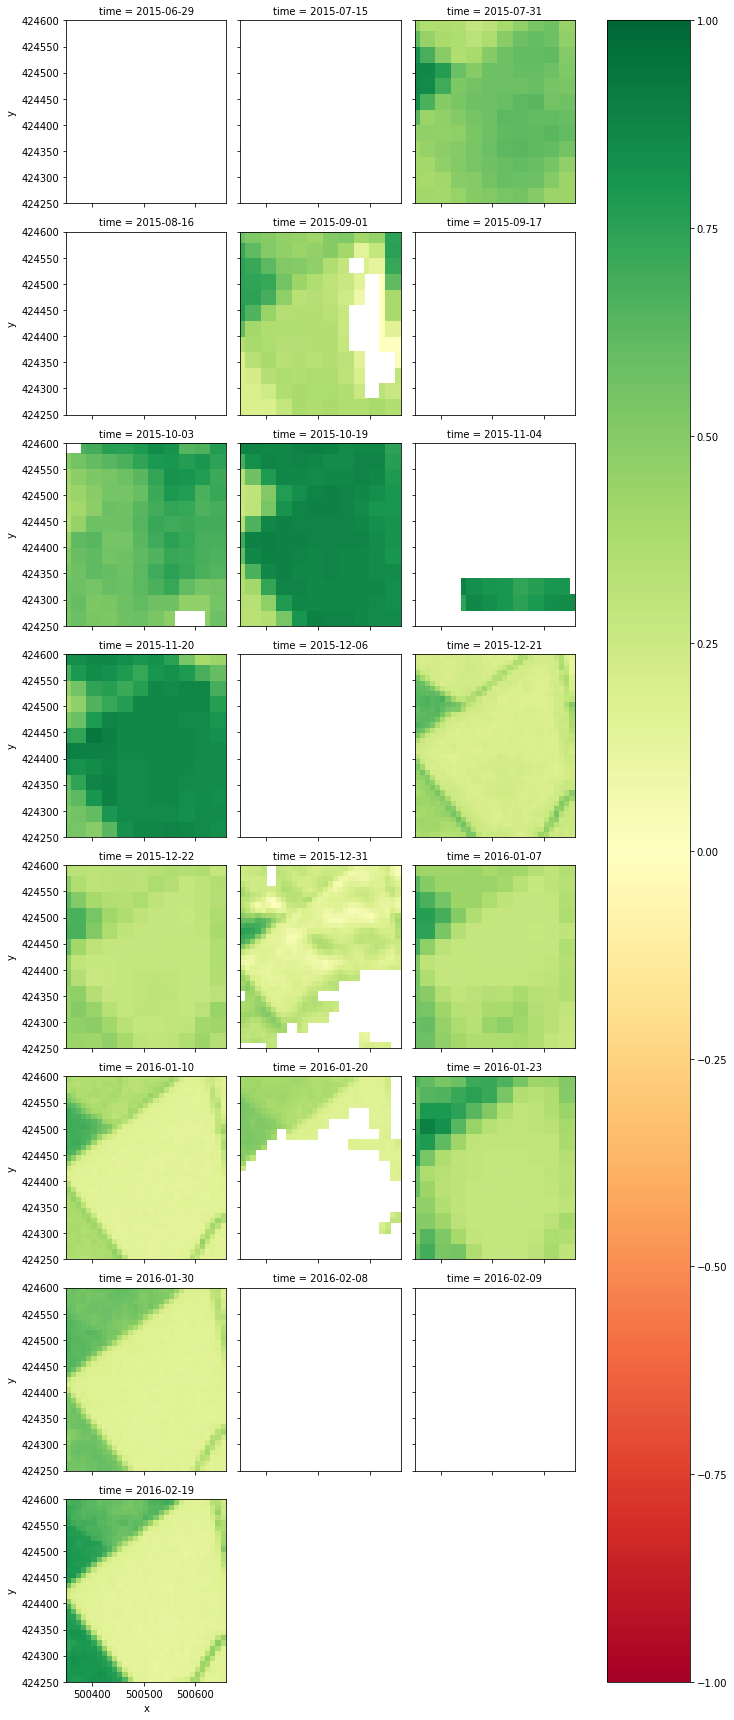

In [88]:
bb = polygon.bounds
xrange = np.arange(bb[0], bb[2], 10)
yrange = np.arange(bb[1], bb[3], 10)

ndvi_region = orig_ts['NDVI'].sel(x=xrange,y=yrange,method='nearest').load()
mask = orig_ts.mask.sel(x=xrange,y=yrange,method='nearest').load()

ndvi_region.where(mask).plot(col='time', col_wrap=3, cmap='RdYlGn', vmax=1, vmin=-1)

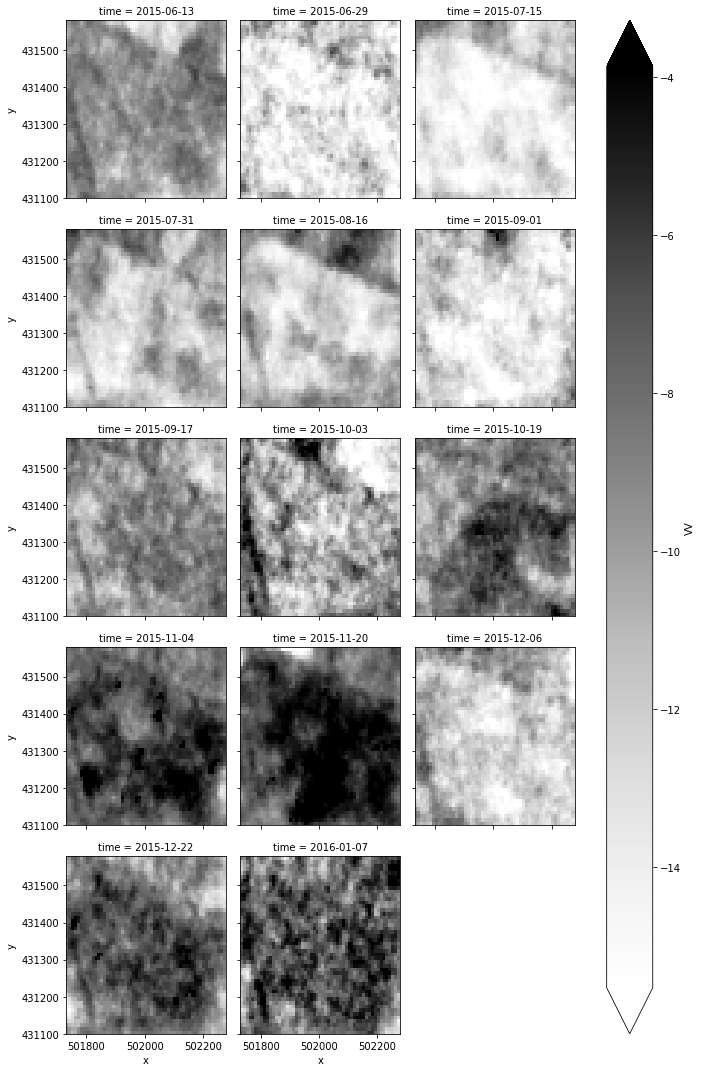

In [24]:
vv_region = int_series['VV'].sel(x=xrange,y=yrange,method='nearest').load()

vv_region.plot(col='time', col_wrap=3, cmap='Greys', robust=True)

### Inspect differences with interpolated dataset

In [27]:
#Retrieve NDVI original dataset
ndvi_orig = xr.open_dataset(vars_location+'NDVI.nc',
                            chunks={'y':100,'x':100,'time':23})
ndvi_orig = ndvi_orig.sortby('time')

In [34]:
def plot_interpolation_diff(original, interpolated, polygon, zlims=(0,1)):
    """
    Plot time-series of a band for points within a polygon of interest
    
    Args:
        dataset (xarray.Dataset): dataset with time series data
        band (str): band to plot
        polygon (shapely.geometry.polygon.Polygon): area of interest
        zlims(tuple(int,int)): limits to y-axis of plot (min,max)
    
    """
    
    bb = polygon.bounds
    
    xrange = np.arange(bb[0], bb[2], 10)
    yrange = np.arange(bb[1], bb[3], 10)
    
    original_ss = original.sel(x=xrange,y=yrange,method='nearest').load()
    interpolated_ss = interpolated.sel(x=xrange,y=yrange,method='nearest').load()
    
    fig, axes = plt.subplots(ncols=2)
    
    axes[0].set_ylim(zlims[0],zlims[1])
    axes[1].set_ylim(zlims[0],zlims[1])
    axes[1].set_xlim(original_ss.time.values[0],original_ss.time.values[-1])
    
    for x in interpolated_ss.x.values:
        for y in interpolated_ss.y.values:
            if geometry.point.Point(x,y).within(polygon):
                original_ss.sel(x=x,y=y).plot.line(ax=axes[0],marker='o')
                interpolated_ss.sel(x=x,y=y).plot.line(ax=axes[1],marker='o')
            else:
                pass
    
    axes[0].set_title('Original time-series')
    axes[1].set_title('Interpolated time-series')
    
    plt.tight_layout()
    
    plt.show()
    

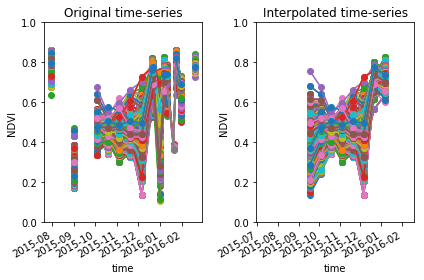

In [35]:
plot_interpolation_diff(ndvi_orig.NDVI, int_series.NDVI, polygon)